In [1]:
import os
import datetime

import numpy as np
import pandas as pd

from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import movingpandas as mpd

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
import seaborn as sns

import folium as fl
from folium.plugins import FastMarkerCluster

# Load Data

In [2]:
def load_vessel_ais_data(path, filename):

    if filename != "17.csv":
        ais = pd.read_csv("".join([path, filename]), delimiter=",").iloc[:, 2:]
    else:
        ais = pd.read_csv("".join([path, filename]), delimiter=";").iloc[:, 2:]
        ais[["LAT", "LON", "SOG", "COG", "Heading", "distanceToPort", "timeToPort"]] = ais[["LAT", "LON", "SOG", "COG", "Heading", "distanceToPort", "timeToPort"]].apply(lambda x: x.str.replace(",", ".").astype("float"), axis=1)

    ais["BaseDateTime"] = pd.to_datetime(ais["BaseDateTime"])
    ais["vessel"] = np.repeat(a=int(filename.split(".")[0]), repeats=ais.shape[0])
    ais = ais[::-1]
    return ais

def load_csvs_in_dir_to_df(dir_path):

    df = pd.DataFrame()
    for file in os.listdir(dir_path):
        if file.endswith(".csv"):
            df = pd.concat((df, load_vessel_ais_data(dir_path, file)), axis=0)
    df.sort_values(by=["vessel", "BaseDateTime"], ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [20]:
df = load_csvs_in_dir_to_df("../data/miami_data/")

/var/folders/20/m3t9trt177390cx_80yzc8wc0000gn/T/ipykernel_2260/1956741285.py:9: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ais["BaseDateTime"] = pd.to_datetime(ais["BaseDateTime"])


In [21]:
df.head()

,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselType,Status,Length,Width,Draft,Cargo,distanceToPort,timeToPort,vessel
0,2021-02-18 19:49:02,22.90467,-78.91242,13.5,-88.3,319.0,70.0,0.0,134.0,22.0,8.7,71.0,184.060232,915.733333,1
1,2021-02-18 19:53:46,22.92118,-78.92096,14.1,-71.7,337.0,70.0,0.0,134.0,22.0,8.7,71.0,182.968530,911.000000,1
2,2021-02-18 20:00:45,22.94673,-78.93176,14.1,-72.3,337.0,70.0,0.0,134.0,22.0,8.7,71.0,181.327811,904.016667,1
3,2021-02-18 20:03:22,22.95611,-78.93592,14.0,-70.2,337.0,70.0,0.0,134.0,22.0,8.7,71.0,180.721544,901.400000,1
4,2021-02-18 20:05:10,22.96262,-78.93882,14.0,-72.9,337.0,70.0,0.0,134.0,22.0,8.7,71.0,180.300520,899.600000,1


# EDA

In [22]:
df = df[["BaseDateTime", "LAT", "LON", "SOG", "COG", "Status",
         "distanceToPort", "timeToPort", "vessel"]]

In [23]:
df.BaseDateTime.max()

Timestamp('2021-03-28 23:57:41')

In [24]:
df.describe()

,BaseDateTime,LAT,LON,SOG,COG,Status,distanceToPort,timeToPort,vessel
count,2157897,2.157897e+06,2.157897e+06,2.157897e+06,2.157897e+06,2.157897e+06,2.042740e+06,2.042740e+06,2.157897e+06
mean,2019-07-28 18:26:13.138666496,2.673430e+01,-8.042582e+01,9.044282e+00,4.679320e+01,1.308653e+00,9.644388e+01,1.540073e+04,1.225098e+02
min,2018-01-01 00:00:02,6.917170e+00,-9.787418e+01,-5.050000e+01,-2.048000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2018-09-22 13:53:58,2.576502e+01,-8.015938e+01,1.000000e-01,-6.960000e+01,0.000000e+00,1.141547e-02,3.624500e+02,5.100000e+01
50%,2019-07-19 18:02:10,2.576629e+01,-8.014415e+01,1.070000e+01,8.210000e+01,0.000000e+00,4.415044e+01,8.400167e+02,1.250000e+02
75%,2020-05-23 05:47:15,2.741316e+01,-7.985707e+01,1.510000e+01,1.723000e+02,5.000000e+00,1.499689e+02,1.738383e+03,1.930000e+02
max,2021-03-28 23:57:41,4.067740e+01,-6.651545e+01,4.890000e+01,2.047000e+02,5.000000e+00,1.506198e+03,1.511279e+06,2.710000e+02
std,NaN,2.208677e+00,1.622492e+00,7.090697e+00,1.284289e+02,2.192971e+00,1.232398e+02,6.559350e+04,7.742205e+01


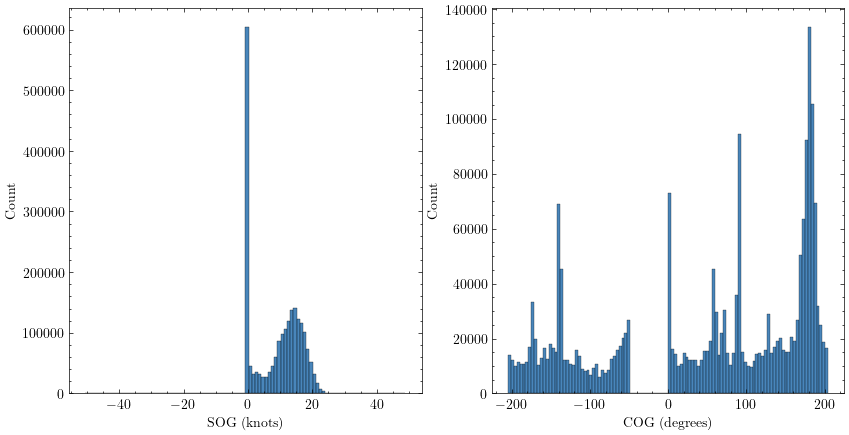

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data=df, x="SOG", bins=100, ax=axs[0])
axs[0].set_xlabel("SOG (knots)")
sns.histplot(data=df, x="COG", ax=axs[1])
axs[1].set_xlabel("COG (degrees)")
plt.savefig("../figures/tese/metodos/miami_data_hist")
plt.show()

# Data Cleaning

In [13]:
df_clean = df.copy()

In [14]:
df_clean["SOG"] = df_clean["SOG"].abs()
df_clean["COG"] = df_clean["COG"] % 360 # the same as summing 360 to negative values
df_clean = df_clean[["BaseDateTime", "LON", "LAT", "SOG", "COG", "Status", "vessel"]]

# Save File

In [15]:
df_clean

,BaseDateTime,LON,LAT,SOG,COG,Status,vessel
0,2021-02-18 19:49:02,-78.91242,22.90467,13.5,271.7,0.0,1
1,2021-02-18 19:53:46,-78.92096,22.92118,14.1,288.3,0.0,1
2,2021-02-18 20:00:45,-78.93176,22.94673,14.1,287.7,0.0,1
3,2021-02-18 20:03:22,-78.93592,22.95611,14.0,289.8,0.0,1
4,2021-02-18 20:05:10,-78.93882,22.96262,14.0,287.1,0.0,1
...,...,...,...,...,...,...,...
2157892,2020-03-15 04:09:26,-80.10817,25.75763,7.2,103.0,5.0,271
2157893,2020-03-15 04:10:37,-80.10546,25.75724,7.9,96.8,5.0,271
2157894,2020-03-15 04:11:48,-80.10266,25.75659,8.2,107.6,5.0,271
2157895,2020-03-15 04:12:56,-80.09989,25.75628,7.9,88.6,5.0,271


In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157897 entries, 0 to 2157896
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   BaseDateTime  datetime64[ns]
 1   LON           float64       
 2   LAT           float64       
 3   SOG           float64       
 4   COG           float64       
 5   Status        float64       
 6   vessel        int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 115.2 MB


In [17]:
df_clean.describe()

,BaseDateTime,LON,LAT,SOG,COG,Status,vessel
count,2157897,2.157897e+06,2.157897e+06,2.157897e+06,2.157897e+06,2.157897e+06,2.157897e+06
mean,2019-07-28 18:26:13.138666496,-8.042582e+01,2.673430e+01,9.044426e+00,1.553811e+02,1.308653e+00,1.225098e+02
min,2018-01-01 00:00:02,-9.787418e+01,6.917170e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2018-09-22 13:53:58,-8.015938e+01,2.576502e+01,1.000000e-01,9.200000e+01,0.000000e+00,5.100000e+01
50%,2019-07-19 18:02:10,-8.014415e+01,2.576629e+01,1.070000e+01,1.750000e+02,0.000000e+00,1.250000e+02
75%,2020-05-23 05:47:15,-7.985707e+01,2.741316e+01,1.510000e+01,1.955000e+02,5.000000e+00,1.930000e+02
max,2021-03-28 23:57:41,-6.651545e+01,4.067740e+01,5.050000e+01,3.104000e+02,5.000000e+00,2.710000e+02
std,NaN,1.622492e+00,2.208677e+00,7.090514e+00,7.620905e+01,2.192971e+00,7.742205e+01


In [ ]:
df_clean.to_csv("../data/1_miami_data.csv", index=False)

# Save Vessels Lengths

In [8]:
def save_vessels_lengths(dir_path):

    vessels_lengths = pd.Series(index=np.arange(1, 272), name="Length") # series of vessels lengths
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            # check if vessel is in the test set data
            vessel_num = int(filename.split(".")[0])

            # get vessel length
            if filename != "17.csv":
                delimiter = ","
            else:
                delimiter = ";"

            
            vessel_length = pd.read_csv(f"{dir_path}{filename}",
                                        delimiter=delimiter,
                                        usecols=["Length"],
                                        nrows=1).iloc[0,0]

            vessels_lengths[vessel_num] = vessel_length
    
    return vessels_lengths

In [10]:
vessels_lengths = save_vessels_lengths("../data/miami_data/")

In [11]:
vessels_lengths.to_csv("../data/final_miami_datasets/vessels_lengths.csv")